In [4]:
# import graph module
import matplotlib.pyplot as plt
import pandas as pd


In [5]:
transactions = pd.read_csv('./dataset/transactions.csv', index_col=False)
transactions.head()

,id,block_id
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [6]:
"""
Timestamp of creation of blocks
"""
dates = pd.read_csv('./dataset/dates.csv', index_col=False)
dates.head()

,block_id,time
0,0,2009-01-03 18:15:05
1,1,2009-01-09 02:54:25
2,2,2009-01-09 02:55:44
3,3,2009-01-09 03:02:53
4,4,2009-01-09 03:16:28


In [7]:
"""
A row for each input appearing in any
transaction and reports the unique identifier of the input, the transaction id
that input appeares in, a sig_id denoting the public key used in the scriptSig,
and the identifier of the output, ouput id, which it is "spending".
"""

# read inputs file
inputs = pd.read_csv('./dataset/inputs.csv', index_col=False)
inputs.head()

,id,tx_id,sig_id,output_id
0,1,1,0,-1
1,2,2,0,-1
2,3,3,0,-1
3,4,4,0,-1
4,5,5,0,-1


In [8]:
"""
A row for each output appearing in any transaction and reports
the unique identifier of the output, the transaction id that output appeared
in, a pk id denoting the public key used in the scriptPubKey and the value
spent.
"""

# read outputs file
outputs = pd.read_csv('./dataset/outputs.csv', index_col=False)
outputs.head()

,id,tx_id,pk_id,value
0,1,1,1,5000000000
1,2,2,2,5000000000
2,3,3,3,5000000000
3,4,4,4,5000000000
4,5,5,5,5000000000


## Question 1: 
### Describe how a real Bitcoin transaction is abstracted by a transaction in  the dataset (which fields are eliminated, which are abstracted and how).

The main fields of bitcoin transaction are:
<ul>
<li><b>hash</b>: identifier of the transaction</li>
<li><b>block_id</b>: id of the block containing this transaction</li>
<li><b>version</b></li>
<li><b>size</b></li>
<li><b>lock_time</b>: blocking time before can add the transaction to the blockchain</li>
<li><b>vin_sz</b></li>
<li><b>vout_sz</b></li>
<li><b>inputs</b></li>
<li><b>outputs</b></li>
<li><b>weight</b></li>
</ul>

From the dataset it is possible to see how several fields were eliminated:
<ul>
<li><b>hash</b></li>
<li><b>version</b></li>
<li><b>size</b></li>
<li><b>lock_time</b></li>
<li><b>vin_sz</b></li>
<li><b>vout_sz</b></li>
<li><b>weight</b></li>
</ul>

For our studies, all <b>hash</b> fields in the datasets has been replaced with a numeric <b>id</b> to reduce the size of the datasets, but the meaning is the same. These fields indicate the unique id of the transaction, input and output and they are also used as pointer, as it possibile to see from the following picture

Moreover, for the inputs, there is a <b>sig_id</b> denoting the public key used in the <b>scriptSig</b>, instead of the <b>scriptSig</b> with values <b>scriptSig_public_key_id</b>, 0 if coinbase tx, -1 if nonstandard scripts used.
As a consequence, for the outputs, there is a <b>pk_id</b> denoting the public key used in the <b>scriptPubKey</b>, instead of the <b>scriptPubKey</b> with values <b>scriptPubKey_public_key_id</b> or -1 if nonstandard scripts used.

DISCORSO ANCHE SUL FATTO DEGLI 0 E -1 ?



## Question 2:
### Check if all the data contained in the dataset is consistent, and if some data is invalid, describe what is the problem of that data and remove it from the dataset.

In [9]:
# Indexing
ID = 0
TX_ID = BLOCK_ID = DATE = 1
SIG_ID = PK_ID = 2
OUTPUT_ID = VALUE = 3

In [10]:
"""
Transform pandas dataframe to a different data structure to increase performance
"""
# Transform inputs dataframe to a list for faster access
inputs_list = inputs.values.tolist()

# Create a set with transaction id as key
transactions_set = {tx[ID] for tx in transactions.values.tolist()}

# Create a dictionary with output id as key and value as the BTC value
outputs_dict = {}

# Create a dictionary with transaction id as key and a list of inputs as value
tx_value_dict = {}

# Iterate over outputs dataframe to create the outputs_dict and tx_value_dict
for row in outputs.values.tolist():
    outputs_dict[row[ID]] = row[VALUE]
    # if the TX_ID is already in the dict, we add the value to the existing value
    if row[TX_ID] in tx_value_dict:
        tx_value_dict[row[TX_ID]] += row[VALUE]
    else:
        tx_value_dict[row[TX_ID]] = row[VALUE]



In [11]:
class Transaction():
    """
    Class method to create a transaction object from a row of inputs, outputs, transactions dataframes
    """
    def __init__(self, tx_id: int, uxto=None, spent=None, address=None, block_id=None, output_id=None):
        self.tx_id = tx_id
        self.uxto = uxto
        self.spent = spent
        self.address = address
        self.block_id = block_id
        self.output_id = output_id

    def __str__(self):
        repr = f'Transaction id: {self.tx_id}'
        if self.uxto is not None:
            repr += f'\nUxto: {self.uxto}'
        if self.spent is not None:
            repr += f'\nSpent: {self.spent}'
        if self.address is not None:
            repr += f'\nAddress: {self.address}'
        if self.block_id is not None:
            repr += f'\nBlock id: {self.block_id}'
        if self.output_id is not None:
            repr += f'\nOutput id: {self.output_id}'
        return repr


class InvalidTransaction(Transaction):
    """
    Class method to create a transaction object from a row of the inputs, outputs, transactions dataframes
    """
    def __init__(self, tx_id: int, invalid_reason: str, uxto=None, spent=None, address=None, block_id=None, output_id=None):
        super().__init__(tx_id, uxto, spent, address, block_id, output_id)
        self.invalid_reason = invalid_reason

    def __str__(self):
        return super().__str__() + f'\nInvalid reason: {self.invalid_reason}'


In [12]:
# Helper functions to check if a transaction is valid or not 

def is_output_id_already_visited(output_id: int, visited_outputs: set) -> bool:
    """
    Check if an output has already been visited
    """
    return output_id in visited_outputs

def exists_in_outputs_dict(output_id: int, outputs_dict: dict) -> bool:
    """
    Check if an output_id exists in the outputs_dict
    """
    return output_id in outputs_dict

def exists_in_transactions_set(tx_id: int, transactions_set: set) -> bool:
    """
    Check if a transaction exists in a list of transactions
    """
    return tx_id in transactions_set


def is_system_generated(sig_id: int) -> bool:
    """
    Check if a transaction is system generated
    """
    return sig_id == 0 or sig_id == -1


def group_same_transactions(i: int, inputs_list: list, visited_outputs: set) -> tuple[list, int, list]:
    """
    Group transactions with the same id starting from the index i and perform a check on the transaction
    """
    

    # append all transaction with the same TX_ID from 'inputs' to a list
    # (they are consecutive, so we can iterate over them only once and skip them in next input row)
    tx_id = inputs_list[i][TX_ID]
    current_transaction_rows = []
    invalid_tx = []
    while i < len(inputs_list) and inputs_list[i][TX_ID] == tx_id:
        current_transaction_rows.append(inputs_list[i])

        # check if the output_id is in the outputs_dict
        output_id = inputs_list[i][OUTPUT_ID]
        if not exists_in_outputs_dict(output_id, outputs_dict):
            # if not, we add the transaction to the invalid_tx list
            invalid_tx.append(InvalidTransaction(tx_id, 'Output not found in outputs dataset'))

        # check if the output_id is already visited
        if is_output_id_already_visited(output_id, visited_outputs):
            # if yes, we add the transaction to the invalid_tx list
            invalid_tx.append(InvalidTransaction(tx_id, 'Output already visited (double spend)'))
        else:
            # if not, we add the output_id to the visited_outputs set
            visited_outputs.add(output_id)

        i += 1
    # return the list and the index of the next row and the invalid_tx list
    return current_transaction_rows, i, invalid_tx


def get_uxto(current_transaction_rows: list) -> int:
    """
    Get the uxto value of a transaction
    """
    # calculate the uxto available for spending in the current transaction
    uxto = 0
    for r in current_transaction_rows:
        # direct access to the value of the output
        out = outputs_dict.get(r[OUTPUT_ID])
        uxto += out
    return uxto


In [13]:
"""
To check if some transaction is invlid:

1. Iterate over all the inputs and check if the output_id is in the outputs_dict
To this in efficient we can use a dictionary to store the output_id as key, and value (BTC spent, uxto) as elements

2. Check that each output_id in the inputs_list has only one id in the outputs_dict

3. Check in tx_value_dict if the TX_ID is in the transactions_set and if the value is greater than the uxto value the transaction is invalid
"""

invalid_tx = []
i = 0
visited_outputs = set()
while i < len(inputs_list):

    # check if the transaction exists in the transactions dataset
    transaction_id = inputs_list[i][TX_ID]
    if not exists_in_transactions_set(transaction_id, transactions_set):
        # if not, we add the transaction to the invalid_tx list
        invalid_tx.append(InvalidTransaction(transaction_id, 'Transaction not found in transactions dataset'))
        # and we skip the next steps
        i += 1
        continue

    # when sig_id = -1 or 0, we don't have to check because the transaction is generated by the system
    sig_id = inputs_list[i][SIG_ID]
    if is_system_generated(sig_id):
        i += 1
        continue

    # append all transaction with the same TX_ID from 'inputs' to a list and update the index
    # of the next input row to be processed if the transaction is valid otherwise we skip the next steps
    current_transaction, i, invalid_transactions = group_same_transactions(i, inputs_list, visited_outputs)
    if invalid_transactions:
        invalid_tx.extend(invalid_transactions)
        continue
    
    # get the current transaction id
    current_transaction_id = current_transaction[0][TX_ID]

    # get the uxto available for spending in the current transaction
    uxto = get_uxto(current_transaction)

    # calculate how much was spent in the current transaction
    spent_in_tx = tx_value_dict.get(current_transaction_id)
    # if the spent value is greater than the uxto, the transaction is invalid
    if spent_in_tx > uxto:
        invalid_tx.append(InvalidTransaction(
            current_transaction_id, 'Spent value greater than uxto',uxto, spent_in_tx))

print('Invalid transactions:')
for t in invalid_tx:
    print(t)
    print("")

Invalid transactions:
Transaction id: 12152
Invalid reason: Output already visited (double spend)

Transaction id: 15698
Invalid reason: Output not found in outputs dataset

Transaction id: 30446
Invalid reason: Output already visited (double spend)

Transaction id: 61845
Invalid reason: Output already visited (double spend)

Transaction id: 100929
Uxto: 5000000000
Spent: 5000000010
Invalid reason: Spent value greater than uxto

Transaction id: 207365
Invalid reason: Output already visited (double spend)



In [14]:
# drop the invalid transactions from the dataframe inputs, outputs and transactions
for tx in invalid_tx:
    inputs.drop(inputs[inputs['tx_id'] == tx.tx_id].index, inplace=True)
    outputs.drop(outputs[outputs['tx_id'] == tx.tx_id].index, inplace=True)
    transactions.drop(transactions[transactions['id'] == tx.tx_id].index, inplace=True)


### Compute the total amount of UTXOs (Unspent Transaction Outputs) existing as of the last block of the data set, i.e. the sum of all the Transaction outputs balances on the UTXO set of the last block. Which UTXO (TxId, blockId, output index and address) has the highest associated value?

In [15]:
"""
Transform pandas dataframe to a different data structure to increase performance
"""

# Create a set of output_id taken from the input dataframe
inputs_set = set([(i[OUTPUT_ID]) for i in inputs.values.tolist()])

# Create a list of transactions
transactions_list = transactions.values.tolist()

# Create a dictionary of transactions
transactions_dict = dict([(t[ID], t[BLOCK_ID]) for t in transactions_list])

# Create a list of outputs
outputs_list = outputs.values.tolist()

# reverse outputs_list
outputs_list.reverse()

# Create a dictionary where the key is the block_id and the value is
# a dictionary with key tx_id and value the sum of value of the outputs_list (UXTO)
# es: 
# {
#       (block_id)3510: {
#           (tx_id)3565: 5000000000, 
#           (tx_id)3566: 100000000000
#       },
#       (block_id)3511: {
#           (tx_id)3567: 5000000000,
#           (tx_id)3568: 100000000000
#       }
# }

# Starts with 0 UXTO value
block_tx_value_dict = {}
for tx in transactions_list:
    block_tx_value_dict.setdefault(tx[BLOCK_ID], {})
    block_tx_value_dict[tx[BLOCK_ID]][tx[ID]] = 0


def exists_in_inputs_set(output_id: int, inputs_set: set) -> bool:
    """
    Check if an output_id is in the inputs_set
    """
    return output_id in inputs_set


In [16]:
"""
Calculate the sum of the value of the outputs_list for each transaction per block,
in the 'outputs' dataset for which the output_id is not in the 'inputs' dataset
(i.e. the output_id is not spent in any previous transaction)
"""
i = 0
max_transaction = None
while i < len(outputs_list):

    z = i
    value = 0

    block_id = transactions_dict.get(outputs_list[i][TX_ID])
    
    # sum the value of the outputs of the same transaction in the same block 
    while i < len(outputs_list) and outputs_list[z][TX_ID] == outputs_list[i][TX_ID]:
        # if the output_id is not in the inputs_set, we add the value to the value of the transaction
        if not exists_in_inputs_set(outputs_list[i][ID], inputs_set):
            value += outputs_list[i][VALUE]
        else:
            # subtract the value of the spent output from the value of the transaction
            value -= outputs_list[i][VALUE]
        i += 1


    # build Transaction object to add to the value of the block in the dictionary 
    transaction = Transaction(
        outputs_list[z][TX_ID], uxto=value, address=outputs_list[z][PK_ID], block_id=block_id, output_id=outputs_list[z][ID])
    block_tx_value_dict[block_id][outputs_list[z][TX_ID]] = transaction
    
    # update the max transaction
    if max_transaction is None or max_transaction.uxto < value:
        max_transaction = transaction

print("Max transaction:")
print(max_transaction)
print("")   


Max transaction:
Transaction id: 140479
Uxto: 9000000000000
Address: 138895
Block id: 90532
Output id: 170430



### Compute the following statistics:


#### the distribution of the block occupancy, i.e. of the number of transactions in each block in the entire period of time.

In [17]:
# compute the len of the values of the block_tx_value_dict
# the len of the values of the block_tx_value_dict is the number of transactions in the block
blocks_len_dict = {}
for block_id, tx_value_dict in block_tx_value_dict.items():
    blocks_len_dict[block_id] = len(tx_value_dict)
print('Blocks \tLen')
# print the biggest blocks
for i, (block_id, len_transactions) in enumerate(blocks_len_dict.items()):
    if len_transactions > 500: 
        print(f'{block_id} \t{len_transactions}')


Blocks 	Len
51734 	628
51746 	707
70194 	776
70885 	548
92052 	728
92084 	507
92109 	584
92959 	850
93006 	834
93007 	763
93073 	850
93085 	800
93122 	850
93632 	708
93640 	837
93707 	510


#### Show the evolution in time of the block size, by considering a time step of one month

In [18]:
from datetime import datetime
"""
Calculate the number of transactions in the block for month 
"""
# calculate the block ids in one month from 'date' dataframe
dates_list = dates.values.tolist()
months_transactions = {}
for date in dates_list:
    d = datetime.strptime(date[DATE], '%Y-%m-%d %H:%M:%S')
    # get the month of the date
    month = d.strftime('%m')
    # get year
    year = d.strftime('%Y')
    # get the block id
    block_id = date[ID]
    # get the number of transactions in the block
    transactions_in_block = blocks_len_dict.get(block_id)
    if transactions_in_block is None:
        transactions_in_block = 0
    # add the number of transactions in the block to the month
    months_transactions.setdefault(year + '-' + month, 0)
    months_transactions[year + '-' + month] += transactions_in_block

print('Year-Months \tTransactions')
for month, transactions in months_transactions.items():
    print(f'{month} \t{transactions}')




Year-Months 	Transactions
2009-01 	2576
2009-02 	3417
2009-03 	3490
2009-04 	3460
2009-05 	3401
2009-06 	2244
2009-07 	1930
2009-08 	1570
2009-09 	2170
2009-10 	2139
2009-11 	2232
2009-12 	4084
2010-01 	5056
2010-02 	5751
2010-03 	5398
2010-04 	9633
2010-05 	6217
2010-06 	6684
2010-07 	26485
2010-08 	11967
2010-09 	13183
2010-10 	14393
2010-11 	63409
2010-12 	15731


Text(0, 0.5, 'Number of transactions')

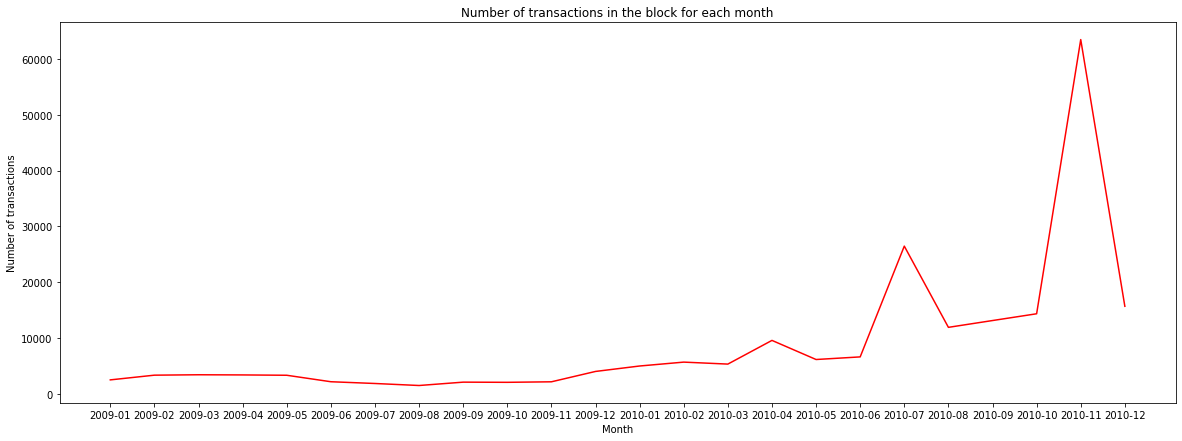

In [19]:
# Build a plot of the number of transactions in the block for each month
import matplotlib.pyplot as plt
x = []
y = []
for month, transactions in months_transactions.items():
    # large plot size
    x.append(month)
    y.append(transactions)
# create a plot with function
# set the title
plt.figure(figsize=(20, 7))
plt.plot(x, y, 'r')
plt.title('Number of transactions in the block for each month')
# set the x label
plt.xlabel('Month')
# set the y label
plt.ylabel('Number of transactions')



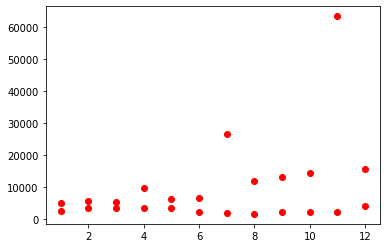

In [20]:
# Build a plot of the number of transactions in the block for each month (comparing to the previous year)
import matplotlib.pyplot as plt
for month, transactions in months_transactions.items():
    d = datetime.strptime(month, '%Y-%m')
    plt.plot(d.month, transactions, 'ro')

#### the total amount of bitcoin received from each public key that has received at least one COINBASE transaction, in the considered period, and show a distribution of the values



In [21]:
# read 'inputs' as a list of values
inputs_list = inputs.values.tolist()

# read 'outputs' as a dict with key transaction id and value a dict with key pk_id and the output value
outputs_dict = {}
for output in outputs_list:
    outputs_dict.setdefault(output[TX_ID], {})
    outputs_dict[output[TX_ID]][output[PK_ID]] = output[VALUE]

# iterate over the list of values and when the OUTPUT_ID is -1,
# get the pk_id from 'outputs' and sum the value of the output
# and add it to the dict with the key pk_id and value the sum of the value of the outputs
    
miners_dict = {}
for i in inputs_list:
    if i[OUTPUT_ID] == -1:
        transaction_id = i[TX_ID]
        pkeys = outputs_dict.get(transaction_id)
        for pkey, value in pkeys.items():
            miners_dict.setdefault(pkey, 0)
            miners_dict[pkey] += value


#miners_dict = dict([(k, v) for k, v in miners_dict.items() if v > 0])
for k, v in miners_dict.items():
    if v > 5000000000:
        print(f'{k}: {v}')


2853: 5201000000
18746: 10000000000
30190: 10000000010
32811: 10000000000
13045: 5003000000
14114: 5010000000
15445: 10000000000
24992: 10000000000
18967: 10000000000
19942: 5014000000
20851: 5013000000
22402: 10000000000
23161: 5012000000
25552: 5012000000
28599: 5022000000
34528: 5026000000
39501: 5044000000
47553: 7500000000
49213: 5026000000
96327: 7500000000
158536: 10000000000
59874: 5671000000
59934: 5264000000
63643: 10000000000
61219: 5099000000
66723: 10000000000
67918: 10000000000
137907: 10000000000
69497: 5137000000
79114: 5001000000
84363: 5003000000
84372: 5001000000
84376: 5001000000
84380: 5002000000
84390: 5003000000
84397: 5001000000
84406: 5001000000
84411: 5001000000
84417: 5001000000
84425: 5001000000
84437: 5001000000
84443: 5001000000
84447: 5002000000
84461: 5001000000
84467: 5001000000
84470: 5002000000
84489: 5001000000
84492: 5001000000
84505: 5001000000
84515: 5001000000
84519: 5001000000
84523: 5001000000
84537: 5001000000
84543: 5001000000
84548: 50020000

In [22]:
"""

"""

# dict with key the block id and value a dict with key the transaction id and value the fees
block_tx_value_dict = {}
for tx in transactions_list:
    block_tx_value_dict.setdefault(tx[BLOCK_ID], {})
    block_tx_value_dict[tx[BLOCK_ID]][tx[ID]] = 0

# create a dict with key the transaction id and value output_id to get the 'input' btc
tx_input_dict = {}
for i in inputs_list:
    if i[SIG_ID] != -1 and i[SIG_ID] != 0:
        tx_input_dict.setdefault(i[TX_ID], [])
    if i[SIG_ID] != -1 and i[SIG_ID] != 0:
        tx_input_dict[i[TX_ID]].append(i[OUTPUT_ID])

# create a dict with key the transaction id and value btc spent in the transaction
tx_spent_dict = {}
for o in outputs_list:
    tx_spent_dict.setdefault(o[TX_ID], 0)
    tx_spent_dict[o[TX_ID]] += o[VALUE]

# get 'outputs' as a dict with output id as key and value the output value (btc)
outputs_dict = dict([(t[ID], t[VALUE]) for t in outputs_list])
n = 0

# for each block, for each transaction, calculate the difference between the sum of the outputs and the sum of the inputs
for block_id in block_tx_value_dict.keys():
    tx_dict = block_tx_value_dict[block_id]
    # for each transaction in a block, calculate the sum of the input
    for tx_id in tx_dict.keys():
        input_sum = 0
        output_sum = 0

        output_ids = tx_input_dict.get(tx_id)
        if output_ids is not None:
            for output_id in output_ids:
                input_sum += outputs_dict.get(output_id)

            output_sum = tx_spent_dict.get(tx_id)

            # calculate the difference between the sum of the outputs and the sum of the inputs
            # if the difference is greater than 0, the transaction contains a miner reward
            # store the fee in the dict with the key the block id and the value dict with key the transaction id
            block_tx_value_dict[block_id][tx_id] = input_sum - output_sum
            if block_tx_value_dict[block_id][tx_id] > 0:
                n += 1

print(f'Number of transactions with miner reward: {n}')


TypeError: unsupported operand type(s) for +=: 'int' and 'NoneType'

### Part 2

Assume a Kademlia network with ID size of **8 bits**. The bucket size is **k = 4**.  
The k-buckets of the peer with **ID 11001010** are as follows:
* **k-Bucket 7**</b>: 01001111, 00110011, 01010101, 00000010
* **k-Bucket 6**</b>: 10110011, 10111000, 10001000
* **k-Bucket 5**</b>: 11101010, 11101110, 11100011, 11110000
* **k-Bucket 4**</b>: 11010011, 11010110
* **k-Bucket 3**</b>: 11000111
* **k-Bucket 2**</b>: 
* **k-Bucket 1**</b>: 
* **k-Bucket 0**</b>:  

You are asked to answer the following questions:
1. Messages from following nodes arrive in this given order: 01101001, 10111000, 11110001, 10101010, 11100011, 11111111.  
How do the buckets, the orderings in the buckets and the waiting lists change?

2. Now the node detects that peer 11101110 cannot be reached anymore, what is the reaction?

3. Which addresses would the peer reply to a lookup looking for ID 11010010?


#### Question 1
Messages from following nodes arrive in this given order: 01101001, 10111000, 11110001, 10101010, 11100011, 11111111.  
How do the buckets, the orderings in the buckets and the waiting lists change?

**Assumption**: according to the class lesson, a node is rejected to enter the bucket when it is full, but in this exercise there is a `waiting_list`, so, the node is placed into it instead of to be rejected. As a consequence, the head node contacted to verify the lifeness always answers.

1. `node = 01101001` should goes to the `k-Bucket7`, the actual node contacts the peer `01001111` (head of the bucket) and it is moved to the tail of the bucket.  
This bucket is full, so the `node = 01101001` is put into the `waiting list` for this bucket.  
- `waiting_list: [01101001]`  
- `k-Bucket7: [00110011, 01010101, 00000010, 01001111]`

2. `node = 10111000` should goes to the `k-Bucket6`, the bucket isn't full, so the node can enters as tail. 
- `k-Bucket6: [10110011, 10111000, 10001000, 10111000]`

3. `node = 11110001` should goes to the `k-Bucket5`, the actual node contacts the peer `11101010` (head of the bucket) and it is moved to the tail of the bucket.  
This bucket is full, so the `node = 11110001` is put into the `waiting list` for this bucket.  
- `waiting_list: [11110001]`  
- `k-Bucket5: [11101110, 11100011, 11110000, 11101010]`

4. `node = 10101010` should goes to the `k-Bucket6`, the actual node contacts the peer `10110011` (head of the bucket) and it is moved to the tail of the bucket.  
This bucket is full, so the `node = 10101010` is put into the `waiting list` for this bucket.  
- `waiting_list: [10101010]`  
- `k-Bucket6: [10111000, 10001000, 10111000, 10110011]`

5. `node = 11100011` should goes to the `k-Bucket5`, it is already in this bucket, so the node is moved to the tail.  
- `waiting_list: [11110001]`  
- `k-Bucket5: [11101110, 11110000, 11101010, 11100011]`

6. `node = 11111111` should goes to the `k-Bucket5`, the actual node contacts the peer `11101110` (head of the bucket) and it is moved to the tail of the bucket.  
This bucket is full, so the `node = 11111111` is put into the `waiting list` for this bucket.  
- `waiting_list: [11110001, 11111111]`  
- `k-Bucket5: [11100011, 11110000, 11101010, 11101110]`

### Question 2
Now the node detects that peer 11101110 cannot be reached anymore, what is the reaction?

1. The head of the `waiting_list` for the `k-Bucket5` is moved to the end of the bucket and the `node = 11101110` is evicted:
- `prev_waiting_list: [11110001, 11111111]`
- `waiting_list: [11111111]`
- `k-Bucket5: [11100011, 11110000, 11101010, 11110001]`




### Question 3
Which addresses would the peer reply to a lookup looking for ID 11010010? 

**Assumption**: `α = 1`

1. The nearest node of the peer belongs to the `k-Bucket4` as it is possible to see from the xor operation 
`k-Bucket4: [11010011, 11010110]`:
`11010011 ⊕ 11010010 = 1`  

`node = 11010011`  




In [ ]:
"""
# read timestamp dataframe with pandas
timestamp_df = pd.read_csv('./dataset/timestamp.csv')
df = timestamp_df.drop(columns=['id'])
df
# read timestamp csv file 
timestamp = pd.read_csv('./dataset/timestamp_cleaned.csv', index_col=False)
#create time column to transactions
transactions['time'] = timestamp['time']
# save to csv
transactions.to_csv('./dataset/transactions_with_timestamp.csv', index=False)
# save the dataframe as a csv file
df.to_csv('./dataset/timestamp_cleaned.csv', index=False)"""